# Prepare to train

**Use pretrained from hugging face**

In [1]:
import random
import numpy as np
import torch

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

**Pytorch Welding Defect Dataset**

In [3]:
from torch.utils.data import Dataset
import os
from PIL import Image

class WeldingDefectDataset(Dataset):
    def __init__(self, root_folder, split, transform=None):
        self.root_folder = root_folder
        if transform is None:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                                 transforms.Resize((224, 224))])
        else:
            self.transform = transform

        self.images, self.labels = self.load_data(split)

    def load_data(self, split):
        if split not in ['train', 'valid', 'test']:
            raise ValueError("Invalid split. Must be 'train' or 'test'.")

        images = []
        labels = []

        images_folder = self.root_folder + f'/{split}/images/'
        labels_folder = self.root_folder + f'/{split}/labels/'

        for img_name in os.listdir(images_folder):
            img_path = os.path.join(images_folder, img_name)
            label_path = os.path.join(labels_folder, img_name.replace('.jpg', '.txt'))

            images.append(img_path)

            with open(label_path, 'r') as f:
                # label is the first character in the file
                label = int(f.read(1))
                labels.append(label)

        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        return img, label

**Train, test function**

In [4]:
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.optim as optim

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        if hasattr(outputs, 'logits'):
            outputs = outputs.logits

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def test(model, test_loader, criterion, device):
    model.eval()
    model.to(device)
    running_loss = 0.0
    all_labels = []
    all_preds = []
    all_time = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            time_taken = end_time - start_time
            all_time.append(time_taken)

            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_time = sum(all_time) / len(all_time)
    return running_loss / len(test_loader), accuracy, f1, avg_time


In [5]:
#device = 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Define hyperparameters**

In [6]:
epochs = 100
batch_size = 32
lr = 0.001
num_classes = 3
patience = 10

In [ ]:
from torch.utils.data import DataLoader, Subset
from collections import Counter
from sklearn.model_selection import train_test_split

root_folder = ''
train_dataset = WeldingDefectDataset(root_folder=root_folder, split='train')
valid_dataset = WeldingDefectDataset(root_folder=root_folder, split='valid')
test_dataset = WeldingDefectDataset(root_folder=root_folder, split='test')

# 0: bad, 1: good, 2: defect
print(f'Train dataset size: {len(train_dataset)}')
print(f'Valid dataset size: {len(valid_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Train dataset class distribution: {Counter(train_dataset.labels)}')
print(f'Valid dataset class distribution: {Counter(valid_dataset.labels)}')
print(f'Test dataset class distribution: {Counter(test_dataset.labels)}')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Train dataset size: 711
Valid dataset size: 237
Test dataset size: 238
Train dataset class distribution: Counter({1: 475, 2: 121, 0: 115})
Valid dataset class distribution: Counter({1: 161, 0: 40, 2: 36})
Test dataset class distribution: Counter({1: 171, 0: 37, 2: 30})


In [8]:
print("Image Shape", train_dataset[0][0].shape)

Image Shape torch.Size([3, 224, 224])


# MobileNetV1

**MobileNetV1 pretrained from transformers HuggingFace**

In [9]:
from transformers import MobileNetV1ForImageClassification

mobilenetv1 = MobileNetV1ForImageClassification.from_pretrained('google/mobilenet_v1_1.0_224')

mobilenetv1.classifier = nn.Linear(mobilenetv1.classifier.in_features, out_features=num_classes, bias=True)
mobilenetv1.dropout = nn.Dropout(p=0.5)

mobilenetv1.to(device)

print(mobilenetv1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv1.parameters(), lr=lr)

MobileNetV1ForImageClassification(
  (mobilenet_v1): MobileNetV1Model(
    (conv_stem): MobileNetV1ConvLayer(
      (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (normalization): BatchNorm2d(32, eps=0.001, momentum=0.9997, affine=True, track_running_stats=True)
      (activation): ReLU6()
    )
    (layer): ModuleList(
      (0): MobileNetV1ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.9997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (1): MobileNetV1ConvLayer(
        (convolution): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(64, eps=0.001, momentum=0.9997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (2): MobileNetV1ConvLayer(
        (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2)

In [10]:
! pip install ptflops



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from ptflops import get_model_complexity_info

#model = MyModel()

macs, params = get_model_complexity_info(mobilenetv1, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
flops = 2 * float(macs.replace('MMac', '')) * 1e6
print(f"FLOPs: {flops}")
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")


MobileNetV1ForImageClassification(
  3.21 M, 100.000% Params, 582.9 MMac, 99.991% MACs, 
  (mobilenet_v1): MobileNetV1Model(
    3.21 M, 99.904% Params, 582.89 MMac, 99.991% MACs, 
    (conv_stem): MobileNetV1ConvLayer(
      928, 0.029% Params, 12.04 MMac, 2.066% MACs, 
      (convolution): Conv2d(864, 0.027% Params, 10.84 MMac, 1.859% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (normalization): BatchNorm2d(64, 0.002% Params, 802.82 KMac, 0.138% MACs, 32, eps=0.001, momentum=0.9997, affine=True, track_running_stats=True)
      (activation): ReLU6(0, 0.000% Params, 401.41 KMac, 0.069% MACs, )
    )
    (layer): ModuleList(
      (0): MobileNetV1ConvLayer(
        352, 0.011% Params, 4.82 MMac, 0.826% MACs, 
        (convolution): Conv2d(288, 0.009% Params, 3.61 MMac, 0.620% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(64, 0.002% Params, 802.82 KMac, 0.138% MACs, 32, eps=0.001, momentum=0.9997, affine=

Epoch 1/100, Train Loss: 0.4785, Valid Loss: 0.2990
Epoch 2/100, Train Loss: 0.1499, Valid Loss: 0.2390
Epoch 3/100, Train Loss: 0.1262, Valid Loss: 1.5172
Epoch 4/100, Train Loss: 0.1574, Valid Loss: 0.3465
Epoch 5/100, Train Loss: 0.1815, Valid Loss: 2.4779
Epoch 6/100, Train Loss: 0.2345, Valid Loss: 1.3444
Epoch 7/100, Train Loss: 0.0867, Valid Loss: 0.3902
Epoch 8/100, Train Loss: 0.0307, Valid Loss: 0.3313
Epoch 9/100, Train Loss: 0.0672, Valid Loss: 0.7258
Epoch 10/100, Train Loss: 0.1631, Valid Loss: 0.5907
Epoch 11/100, Train Loss: 0.0577, Valid Loss: 0.7738
Epoch 12/100, Train Loss: 0.0454, Valid Loss: 0.3513
Epoch 13/100, Train Loss: 0.0498, Valid Loss: 0.4682
Epoch 14/100, Train Loss: 0.0660, Valid Loss: 0.8583
Epoch 15/100, Train Loss: 0.0304, Valid Loss: 0.6851
Epoch 16/100, Train Loss: 0.0201, Valid Loss: 0.6733
Epoch 17/100, Train Loss: 0.0264, Valid Loss: 0.4131
Epoch 18/100, Train Loss: 0.0280, Valid Loss: 0.3006
Epoch 19/100, Train Loss: 0.0302, Valid Loss: 0.8352
Ep

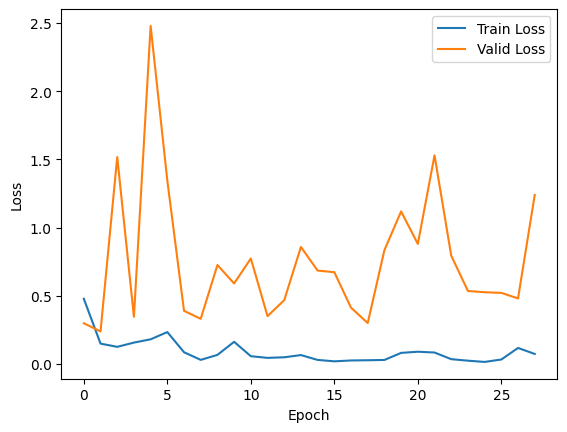

In [12]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(mobilenetv1, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(mobilenetv1, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv1, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.85, Test F1-Score: 0.83, Avg Time: 0.0084 seconds


In [14]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv1, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.85, Test F1-Score: 0.83, Avg Time: 0.0177 seconds


In [54]:
#save model
mobilenetv1.eval()
torch.save(mobilenetv1.state_dict(), 'WeldingDefectModels/mobilenetv1.pth')

# MobileNetV2

**MobileNetV2 pretrained from transformers HuggingFace**

In [16]:
from transformers import MobileNetV2ForImageClassification

mobilenetv2 = MobileNetV2ForImageClassification.from_pretrained('google/mobilenet_v2_1.0_224')

mobilenetv2.classifier = nn.Linear(mobilenetv2.classifier.in_features, out_features=num_classes, bias=True)

mobilenetv2.to(device)

print(mobilenetv2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv2.parameters(), lr=lr)

MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

In [17]:
from ptflops import get_model_complexity_info

#model = MyModel()

macs, params = get_model_complexity_info(mobilenetv2, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
flops = 2 * float(macs.replace('MMac', '')) * 1e6
print(f"FLOPs: {flops}")
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")


MobileNetV2ForImageClassification(
  2.23 M, 100.000% Params, 319.02 MMac, 99.980% MACs, 
  (mobilenet_v2): MobileNetV2Model(
    2.22 M, 99.827% Params, 319.02 MMac, 99.979% MACs, 
    (conv_stem): MobileNetV2Stem(
      1.82 k, 0.082% Params, 23.68 MMac, 7.422% MACs, 
      (first_conv): MobileNetV2ConvLayer(
        928, 0.042% Params, 12.04 MMac, 3.774% MACs, 
        (convolution): Conv2d(864, 0.039% Params, 10.84 MMac, 3.397% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(64, 0.003% Params, 802.82 KMac, 0.252% MACs, 32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6(0, 0.000% Params, 401.41 KMac, 0.126% MACs, )
      )
      (conv_3x3): MobileNetV2ConvLayer(
        352, 0.016% Params, 4.82 MMac, 1.510% MACs, 
        (convolution): Conv2d(288, 0.013% Params, 3.61 MMac, 1.132% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(

Epoch 1/100, Train Loss: 0.4734, Valid Loss: 0.7712
Epoch 2/100, Train Loss: 0.1656, Valid Loss: 0.7507
Epoch 3/100, Train Loss: 0.2145, Valid Loss: 1.0069
Epoch 4/100, Train Loss: 0.1348, Valid Loss: 0.8467
Epoch 5/100, Train Loss: 0.1468, Valid Loss: 0.4207
Epoch 6/100, Train Loss: 0.0830, Valid Loss: 1.0313
Epoch 7/100, Train Loss: 0.0344, Valid Loss: 0.7501
Epoch 8/100, Train Loss: 0.0661, Valid Loss: 0.7725
Epoch 9/100, Train Loss: 0.2439, Valid Loss: 0.5831
Epoch 10/100, Train Loss: 0.1749, Valid Loss: 0.3957
Epoch 11/100, Train Loss: 0.1790, Valid Loss: 0.4135
Epoch 12/100, Train Loss: 0.1284, Valid Loss: 0.2855
Epoch 13/100, Train Loss: 0.0239, Valid Loss: 0.2984
Epoch 14/100, Train Loss: 0.0181, Valid Loss: 0.3019
Epoch 15/100, Train Loss: 0.0193, Valid Loss: 0.5378
Epoch 16/100, Train Loss: 0.0054, Valid Loss: 0.3364
Epoch 17/100, Train Loss: 0.0058, Valid Loss: 0.4350
Epoch 18/100, Train Loss: 0.0397, Valid Loss: 0.3432
Epoch 19/100, Train Loss: 0.2463, Valid Loss: 1.1558
Ep

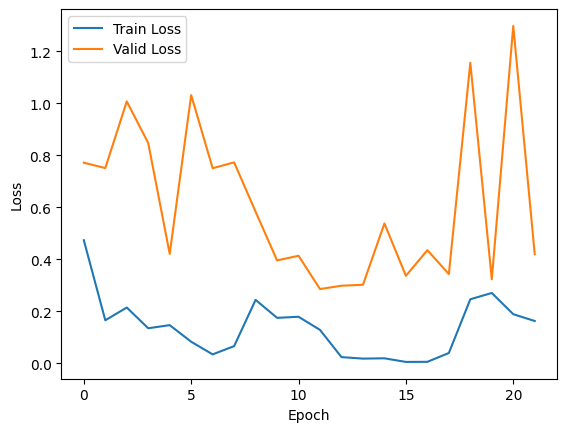

In [18]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(mobilenetv2, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(mobilenetv2, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv2, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.91, Test F1-Score: 0.91, Avg Time: 0.0119 seconds


In [20]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv2, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.91, Test F1-Score: 0.91, Avg Time: 0.0206 seconds


In [55]:
#save model
torch.save(mobilenetv2.state_dict(), 'WeldingDefectModels/mobilenetv2.pth')

# MobileNetV3

**MobileNetV3 pretrained from torchvision**

In [22]:
from torchvision.models import mobilenet_v3_small,  MobileNet_V3_Small_Weights

mobilenetv3 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

mobilenetv3.classifier[3] = nn.Linear(mobilenetv3.classifier[3].in_features, out_features=num_classes, bias=True)

mobilenetv3.to(device)

print(mobilenetv3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3.parameters(), lr=lr)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [23]:
from ptflops import get_model_complexity_info

#model = MyModel()

macs, params = get_model_complexity_info(mobilenetv3, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
flops = 2 * float(macs.replace('MMac', '')) * 1e6
print(f"FLOPs: {flops}")
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")


MobileNetV3(
  1.52 M, 100.000% Params, 59.1 MMac, 98.690% MACs, 
  (features): Sequential(
    927.01 k, 60.950% Params, 58.48 MMac, 97.651% MACs, 
    (0): Conv2dNormActivation(
      464, 0.031% Params, 5.82 MMac, 9.719% MACs, 
      (0): Conv2d(432, 0.028% Params, 5.42 MMac, 9.049% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, 0.002% Params, 401.41 KMac, 0.670% MACs, 16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    )
    (1): InvertedResidual(
      744, 0.049% Params, 1.56 MMac, 2.598% MACs, 
      (block): Sequential(
        744, 0.049% Params, 1.56 MMac, 2.598% MACs, 
        (0): Conv2dNormActivation(
          176, 0.012% Params, 602.11 KMac, 1.005% MACs, 
          (0): Conv2d(144, 0.009% Params, 451.58 KMac, 0.754% MACs, 16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(32, 

Epoch 1/100, Train Loss: 0.6367, Valid Loss: 1.2943
Epoch 2/100, Train Loss: 0.2395, Valid Loss: 1.6790
Epoch 3/100, Train Loss: 0.0751, Valid Loss: 2.1083
Epoch 4/100, Train Loss: 0.0785, Valid Loss: 1.9201
Epoch 5/100, Train Loss: 0.0369, Valid Loss: 0.4154
Epoch 6/100, Train Loss: 0.0281, Valid Loss: 0.6514
Epoch 7/100, Train Loss: 0.0436, Valid Loss: 1.0221
Epoch 8/100, Train Loss: 0.0249, Valid Loss: 0.7590
Epoch 9/100, Train Loss: 0.0490, Valid Loss: 0.5041
Epoch 10/100, Train Loss: 0.1323, Valid Loss: 2.5591
Epoch 11/100, Train Loss: 0.0792, Valid Loss: 0.4837
Epoch 12/100, Train Loss: 0.0839, Valid Loss: 0.7070
Epoch 13/100, Train Loss: 0.0935, Valid Loss: 0.8295
Epoch 14/100, Train Loss: 0.0554, Valid Loss: 0.6867
Epoch 15/100, Train Loss: 0.0139, Valid Loss: 0.6110
Epoch 16/100, Train Loss: 0.0035, Valid Loss: 0.4345
Epoch 17/100, Train Loss: 0.0022, Valid Loss: 0.3396
Epoch 18/100, Train Loss: 0.0014, Valid Loss: 0.2938
Epoch 19/100, Train Loss: 0.0007, Valid Loss: 0.2641
Ep

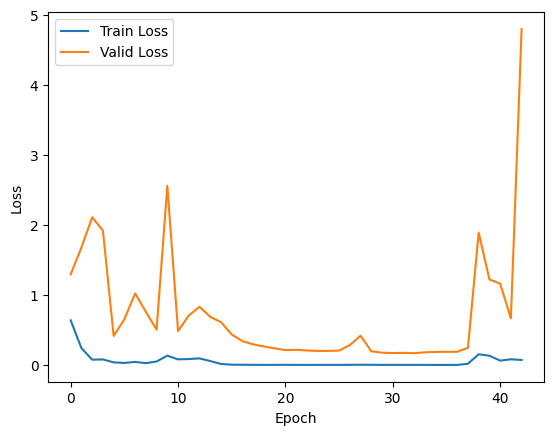

In [24]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(mobilenetv3, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(mobilenetv3, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv3, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.80, Test F1-Score: 0.76, Avg Time: 0.0082 seconds


In [26]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv3, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.80, Test F1-Score: 0.76, Avg Time: 0.0076 seconds


In [56]:
#save model
torch.save(mobilenetv3.state_dict(), 'WeldingDefectModels/mobilenetv3.pth')

# MobileNetV4

MobileNetV4 pretrained from timm HuggingFace

In [28]:
import timm

mobilenetv4 = timm.create_model('mobilenetv4_hybrid_medium.e500_r224_in1k', pretrained=True, num_classes=num_classes)

mobilenetv4.to(device)

print(mobilenetv4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv4.parameters(), lr=lr)

MobileNetV3(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pwl): Conv2d(128, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): Uni

In [29]:
from ptflops import get_model_complexity_info

#model = MyModel()

macs, params = get_model_complexity_info(mobilenetv4, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
flops = 2 * float(macs.replace('MMac', '')) * 1e6
print(f"FLOPs: {flops}")
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")


MobileNetV3(
  9.71 M, 99.150% Params, 945.2 MMac, 99.513% MACs, 
  (conv_stem): Conv2d(864, 0.009% Params, 10.84 MMac, 1.141% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    0, 0.000% Params, 401.41 KMac, 0.042% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (act): ReLU(0, 0.000% Params, 401.41 KMac, 0.042% MACs, inplace=True)
  )
  (blocks): Sequential(
    8.48 M, 86.599% Params, 932.68 MMac, 98.195% MACs, 
    (0): Sequential(
      43.01 k, 0.439% Params, 135.27 MMac, 14.242% MACs, 
      (0): EdgeResidual(
        43.01 k, 0.439% Params, 135.27 MMac, 14.242% MACs, 
        (conv_exp): Conv2d(36.86 k, 0.376% Params, 115.61 MMac, 12.171% MACs, 32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          0, 0.000% Params, 401.41 KMac, 0.042% MACs, 128, eps=1e-05, momentum=0.1, affine=

Epoch 1/100, Train Loss: 5.1453, Valid Loss: 1202.1262
Epoch 2/100, Train Loss: 1.6032, Valid Loss: 4.6129
Epoch 3/100, Train Loss: 0.8750, Valid Loss: 0.8784
Epoch 4/100, Train Loss: 0.7337, Valid Loss: 0.7765
Epoch 5/100, Train Loss: 0.6894, Valid Loss: 0.6984
Epoch 6/100, Train Loss: 0.6583, Valid Loss: 0.8745
Epoch 7/100, Train Loss: 0.5333, Valid Loss: 0.9191
Epoch 8/100, Train Loss: 0.5273, Valid Loss: 0.7080
Epoch 9/100, Train Loss: 0.5169, Valid Loss: 0.7323
Epoch 10/100, Train Loss: 0.5820, Valid Loss: 0.6530
Epoch 11/100, Train Loss: 0.8906, Valid Loss: 28.4684
Epoch 12/100, Train Loss: 0.7719, Valid Loss: 1.1203
Epoch 13/100, Train Loss: 0.5967, Valid Loss: 0.9717
Epoch 14/100, Train Loss: 0.7036, Valid Loss: 1.3463
Epoch 15/100, Train Loss: 0.6595, Valid Loss: 1.2179
Epoch 16/100, Train Loss: 0.6717, Valid Loss: 5.5920
Epoch 17/100, Train Loss: 0.6755, Valid Loss: 1.0335
Epoch 18/100, Train Loss: 0.7430, Valid Loss: 10.9994
Epoch 19/100, Train Loss: 0.8059, Valid Loss: 21.2

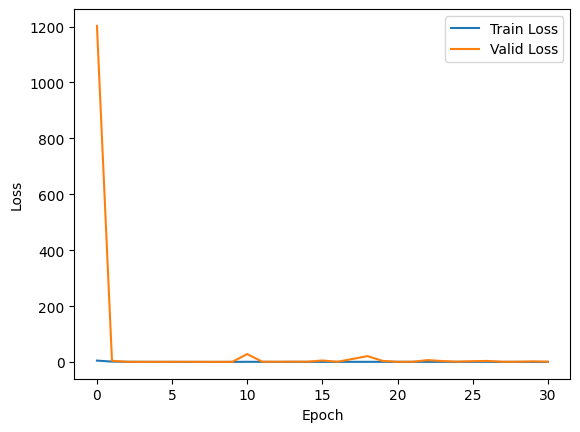

In [30]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(mobilenetv4, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(mobilenetv4, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv4, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.75, Test F1-Score: 0.72, Avg Time: 0.0226 seconds


In [32]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv4, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.75, Test F1-Score: 0.72, Avg Time: 0.0311 seconds


In [57]:
#save model
torch.save(mobilenetv4.state_dict(), 'WeldingDefectModels/mobilenetv4.pth')

# EfficientFormer

In [34]:
import timm

efficientformer = timm.create_model('efficientformerv2_s2.snap_dist_in1k', pretrained=True, num_classes=num_classes)

efficientformer.to(device)

print(efficientformer)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientformer.parameters(), lr=lr)

EfficientFormerV2(
  (stem): Stem4(
    (conv1): ConvNormAct(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNormAct2d(
        16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): GELU()
      )
    )
    (conv2): ConvNormAct(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): GELU()
      )
    )
  )
  (stages): Sequential(
    (0): EfficientFormerV2Stage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): EfficientFormerV2Block(
          (mlp): ConvMlpWithNorm(
            (fc1): ConvNormAct(
              (conv): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
              (bn): BatchNormAct2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
     

In [35]:
from ptflops import get_model_complexity_info

#model = MyModel()

macs, params = get_model_complexity_info(efficientformer, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
flops = 2 * float(macs.replace('GMac', '')) * 1e6
print(f"FLOPs: {flops}")
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")


EfficientFormerV2(
  12.06 M, 99.394% Params, 1.23 GMac, 99.184% MACs, 
  (stem): Stem4(
    5.09 k, 0.042% Params, 20.17 MMac, 1.623% MACs, 
    (conv1): ConvNormAct(
      448, 0.004% Params, 5.62 MMac, 0.452% MACs, 
      (conv): Conv2d(448, 0.004% Params, 5.62 MMac, 0.452% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNormAct2d(
        0, 0.000% Params, 0.0 Mac, 0.000% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
        (act): GELU(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
      )
    )
    (conv2): ConvNormAct(
      4.64 k, 0.038% Params, 14.55 MMac, 1.171% MACs, 
      (conv): Conv2d(4.64 k, 0.038% Params, 14.55 MMac, 1.171% MACs, 16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNormAct2d(
        0, 0.000% Params, 0.0 Mac, 0.000% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Iden

Epoch 1/100, Train Loss: 0.6667, Valid Loss: 0.8490
Epoch 2/100, Train Loss: 0.2422, Valid Loss: 6.4036
Epoch 3/100, Train Loss: 0.1858, Valid Loss: 0.6111
Epoch 4/100, Train Loss: 0.2038, Valid Loss: 3.1843
Epoch 5/100, Train Loss: 0.1300, Valid Loss: 0.7553
Epoch 6/100, Train Loss: 0.1055, Valid Loss: 0.1839
Epoch 7/100, Train Loss: 0.1226, Valid Loss: 0.3346
Epoch 8/100, Train Loss: 0.1606, Valid Loss: 0.1115
Epoch 9/100, Train Loss: 0.1197, Valid Loss: 0.4518
Epoch 10/100, Train Loss: 0.0926, Valid Loss: 0.1496
Epoch 11/100, Train Loss: 0.0994, Valid Loss: 0.3589
Epoch 12/100, Train Loss: 0.0526, Valid Loss: 0.2485
Epoch 13/100, Train Loss: 0.0183, Valid Loss: 0.1337
Epoch 14/100, Train Loss: 0.0409, Valid Loss: 0.1755
Epoch 15/100, Train Loss: 0.1780, Valid Loss: 0.3303
Epoch 16/100, Train Loss: 0.0840, Valid Loss: 0.1548
Epoch 17/100, Train Loss: 0.0308, Valid Loss: 0.2548
Epoch 18/100, Train Loss: 0.0089, Valid Loss: 0.2763
Epoch 19/100, Train Loss: 0.0196, Valid Loss: 0.2053
Ep

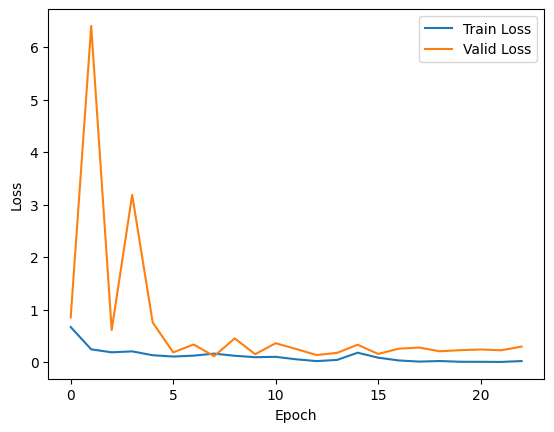

In [36]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(efficientformer, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(efficientformer, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
_, test_accuracy, test_f1, avg_time = test(efficientformer, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.93, Test F1-Score: 0.93, Avg Time: 0.0277 seconds


In [38]:
_, test_accuracy, test_f1, avg_time = test(efficientformer, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.93, Test F1-Score: 0.93, Avg Time: 0.0464 seconds


In [58]:
#save model
torch.save(efficientformer.state_dict(), 'WeldingDefectModels/efficientformer.pth')

# SBCFormer

In [40]:
from SBCFormer.models.sbcformer import SBCFormer_B
import torch
import torch.nn as nn

sbcformer = SBCFormer_B()

# load checkpoint
checkpoint = torch.load('D:/HocTap/NCKH/LightweightModels/SBCFormer_B_IMNET_checkpoint.pth')

sbcformer.load_state_dict(checkpoint['model'], strict=False)

sbcformer.head = nn.Linear(sbcformer.head.in_features, out_features=3, bias=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(sbcformer.parameters(), lr=lr)

sbcformer.to(device)

c:\Python312\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Python312\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
d:\HocTap\NCKH\LightweightModels\SBCFormer\models\deit.py:89: UserWarning: Overwriting deit_tiny_patch16_224 in registry with SBCFormer.models.deit.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
d:\HocTap\NCKH\LightweightModels\SBCFormer\models\deit.py:104: UserWarning: Overwriting deit_small_patch16_224 in registry with SBCFormer.models.deit.deit_small_patch16_224

SBCFormer(
  (merging_blocks): ModuleList(
    (0): PatchEmbed(
      (stem): Sequential(
        (0): Conv2d_BN(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ReLU(inplace=True)
        (2): Conv2d_BN(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (3): ReLU(inplace=True)
        (4): Conv2d_BN(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (5): ReLU(inplace=True)
      )
    )
    (1): PatchMerging(
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [41]:
from ptflops import get_model_complexity_info

#model = MyModel()

macs, params = get_model_complexity_info(sbcformer, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
flops = 2 * float(macs.replace('GMac', '')) * 1e6
print(f"FLOPs: {flops}")
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")


SBCFormer(
  20.68 M, 153.760% Params, 1.56 GMac, 99.805% MACs, 
  (merging_blocks): ModuleList(
    (0): PatchEmbed(
      93.47 k, 0.695% Params, 128.55 MMac, 8.248% MACs, 
      (stem): Sequential(
        93.47 k, 0.695% Params, 128.55 MMac, 8.248% MACs, 
        (0): Conv2d_BN(
          928, 0.007% Params, 11.64 MMac, 0.747% MACs, 
          (conv): Conv2d(864, 0.006% Params, 10.84 MMac, 0.695% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, 0.000% Params, 802.82 KMac, 0.052% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ReLU(0, 0.000% Params, 401.41 KMac, 0.026% MACs, inplace=True)
        (2): Conv2d_BN(
          18.56 k, 0.138% Params, 58.2 MMac, 3.735% MACs, 
          (conv): Conv2d(18.43 k, 0.137% Params, 57.8 MMac, 3.709% MACs, 32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, 0.001% Params, 401.41 KMac, 0.026

Epoch 1/100, Train Loss: 0.6128, Valid Loss: 0.5921, Valid Accuracy: 0.7932, Valid F1-Score: 0.7437
Epoch 2/100, Train Loss: 0.3648, Valid Loss: 0.2458, Valid Accuracy: 0.9409, Valid F1-Score: 0.9417
Epoch 3/100, Train Loss: 0.2757, Valid Loss: 0.2936, Valid Accuracy: 0.9241, Valid F1-Score: 0.9233
Epoch 4/100, Train Loss: 0.2100, Valid Loss: 0.3695, Valid Accuracy: 0.9156, Valid F1-Score: 0.9129
Epoch 5/100, Train Loss: 0.2135, Valid Loss: 0.4479, Valid Accuracy: 0.8565, Valid F1-Score: 0.8556
Epoch 6/100, Train Loss: 0.1790, Valid Loss: 0.3374, Valid Accuracy: 0.8945, Valid F1-Score: 0.8924
Epoch 7/100, Train Loss: 0.1999, Valid Loss: 0.3291, Valid Accuracy: 0.8861, Valid F1-Score: 0.8905
Epoch 8/100, Train Loss: 0.3246, Valid Loss: 0.4332, Valid Accuracy: 0.8523, Valid F1-Score: 0.8512
Epoch 9/100, Train Loss: 0.2352, Valid Loss: 0.7382, Valid Accuracy: 0.8312, Valid F1-Score: 0.7933
Epoch 10/100, Train Loss: 0.1237, Valid Loss: 0.3018, Valid Accuracy: 0.9030, Valid F1-Score: 0.9063

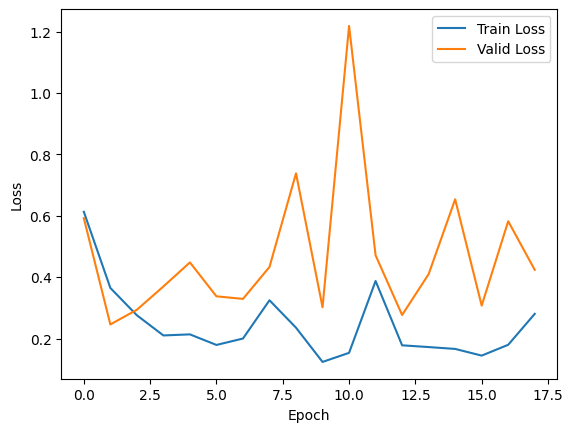

In [42]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(sbcformer, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(sbcformer, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}, Valid Accuracy: {val_accuracy:.4f}, Valid F1-Score: {val_f1:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= 5:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
_, test_accuracy, test_f1, avg_time = test(sbcformer, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.87, Test F1-Score: 0.87, Avg Time: 0.0174 seconds


In [46]:
_, test_accuracy, test_f1, avg_time = test(sbcformer, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.87, Test F1-Score: 0.87, Avg Time: 0.0276 seconds


In [59]:
#save model
torch.save(sbcformer.state_dict(), 'WeldingDefectModels/sbcformer.pth')

In [48]:
import timm

resnet50 = timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=num_classes)

resnet50.to(device)

print(resnet50)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=lr)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [49]:
from ptflops import get_model_complexity_info

#model = MyModel()

macs, params = get_model_complexity_info(resnet50, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
flops = 2 * float(macs.replace('GMac', '')) * 1e6
print(f"FLOPs: {flops}")
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")

ResNet(
  23.51 M, 100.000% Params, 4.12 GMac, 99.745% MACs, 
  (conv1): Conv2d(9.41 k, 0.040% Params, 118.01 MMac, 2.857% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(128, 0.001% Params, 1.61 MMac, 0.039% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(0, 0.000% Params, 802.82 KMac, 0.019% MACs, inplace=True)
  (maxpool): MaxPool2d(0, 0.000% Params, 802.82 KMac, 0.019% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    215.81 k, 0.918% Params, 680.39 MMac, 16.473% MACs, 
    (0): Bottleneck(
      75.01 k, 0.319% Params, 236.43 MMac, 5.724% MACs, 
      (conv1): Conv2d(4.1 k, 0.017% Params, 12.85 MMac, 0.311% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, 0.001% Params, 401.41 KMac, 0.010% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(0, 0.000% Params, 200.

Epoch 1/100, Train Loss: 0.7339, Valid Loss: 0.7526
Epoch 2/100, Train Loss: 0.4026, Valid Loss: 0.5595
Epoch 3/100, Train Loss: 0.2054, Valid Loss: 0.2411
Epoch 4/100, Train Loss: 0.1064, Valid Loss: 0.3508
Epoch 5/100, Train Loss: 0.0742, Valid Loss: 0.3419
Epoch 6/100, Train Loss: 0.0329, Valid Loss: 0.2289
Epoch 7/100, Train Loss: 0.0363, Valid Loss: 0.2125
Epoch 8/100, Train Loss: 0.0543, Valid Loss: 0.3864
Epoch 9/100, Train Loss: 0.0411, Valid Loss: 0.1967
Epoch 10/100, Train Loss: 0.0193, Valid Loss: 0.1342
Epoch 11/100, Train Loss: 0.0248, Valid Loss: 0.1207
Epoch 12/100, Train Loss: 0.0500, Valid Loss: 0.3090
Epoch 13/100, Train Loss: 0.0605, Valid Loss: 0.4573
Epoch 14/100, Train Loss: 0.0363, Valid Loss: 0.1754
Epoch 15/100, Train Loss: 0.0796, Valid Loss: 0.2031
Epoch 16/100, Train Loss: 0.0654, Valid Loss: 0.3417
Epoch 17/100, Train Loss: 0.0613, Valid Loss: 0.2637
Epoch 18/100, Train Loss: 0.0622, Valid Loss: 0.2087
Epoch 19/100, Train Loss: 0.0597, Valid Loss: 0.3327
Ep

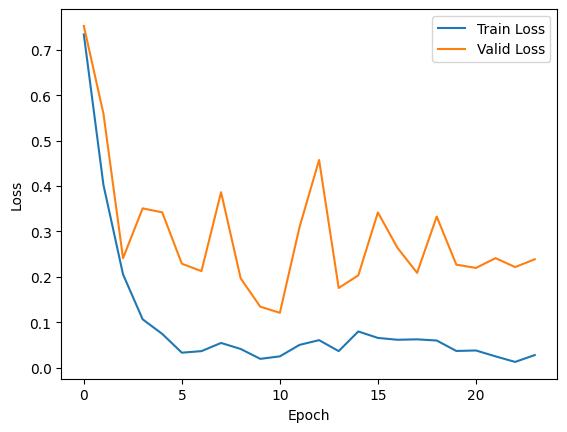

In [50]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(resnet50, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(resnet50, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
_, test_accuracy, test_f1, avg_time = test(resnet50, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.93, Test F1-Score: 0.93, Avg Time: 0.0085 seconds


In [52]:
_, test_accuracy, test_f1, avg_time = test(resnet50, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.93, Test F1-Score: 0.93, Avg Time: 0.0469 seconds


In [53]:
#save model
torch.save(resnet50.state_dict(), 'WeldingDefectModels/resnet50.pth')